In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import xlsxwriter
import pandas as pd # Excel
import struct # Binary writing

import scipy.io as sio # Read .mat files
import h5py

import time

from grading import *

import scipy.signal
import scipy.ndimage

import sklearn.metrics as skmet
import sklearn.decomposition as skdec
import sklearn.linear_model as sklin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import neighbors

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


### Calculate LBP features from .dat mean and std images

['13_R3L_2_PTA_48h_Rec_surface_mean.dat', '13_R3L_2_PTA_48h_Rec_surface_std.dat', '13_R6TL_2_PTA_48h_Rec_surface_mean.dat', '13_R6TL_2_PTA_48h_Rec_surface_std.dat', '14_R3L_2_PTA_48h_Rec_surface_mean.dat', '14_R3L_2_PTA_48h_Rec_surface_std.dat', '14_R6LT_2_PTA_48h_Rec_surface_mean.dat', '14_R6LT_2_PTA_48h_Rec_surface_std.dat', '15_L3L_2_PTA_48h_Rec_surface_mean.dat', '15_L3L_2_PTA_48h_Rec_surface_std.dat', '15_L6TL_2_PTA_48h_Rec_surface_mean.dat', '15_L6TL_2_PTA_48h_Rec_surface_std.dat', '15_L6TL_2_surface_mean.dat', '15_L6TL_2_surface_std.dat', '20_R2M_2_PTA_48h_Rec_surface_mean.dat', '20_R2M_2_PTA_48h_Rec_surface_std.dat', '20_R6TM_2_PTA_48h_Rec_surface_mean.dat', '20_R6TM_2_PTA_48h_Rec_surface_std.dat', '21_L3L_2_PTA_48h_Rec_surface_mean.dat', '21_L3L_2_PTA_48h_Rec_surface_std.dat', '21_L6LT_1_PTA_48h_Rec_surface_mean.dat', '21_L6LT_1_PTA_48h_Rec_surface_std.dat', '22_L3L_2_PTA_48h_Rec_surface_mean.dat', '22_L3L_2_PTA_48h_Rec_surface_std.dat', '22_L6TL_2_PTA_48h_Rec_surface_mean.dat

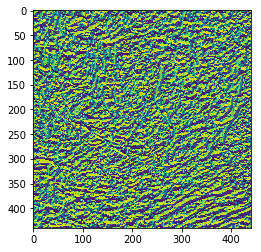

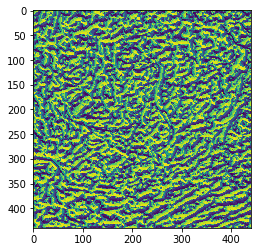

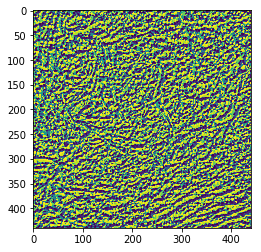

Processing: 13_R6TL_2_PTA_48h_Rec_surface_mean.dat


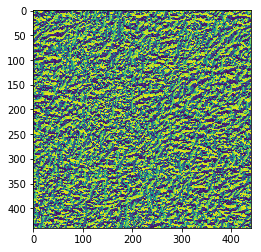

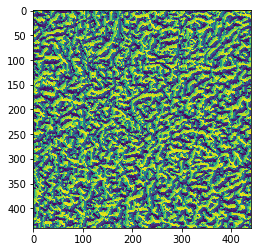

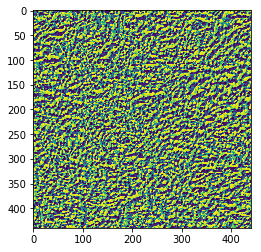

Processing: 14_R3L_2_PTA_48h_Rec_surface_mean.dat


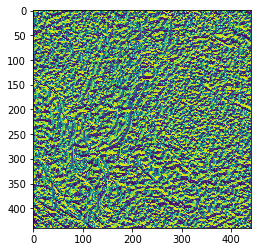

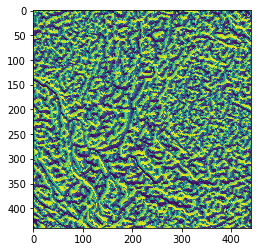

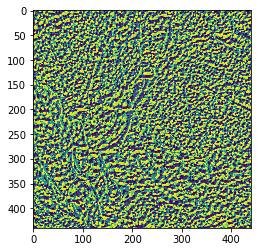

Processing: 14_R6LT_2_PTA_48h_Rec_surface_mean.dat


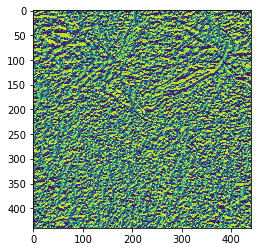

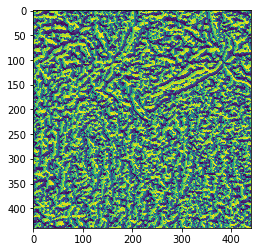

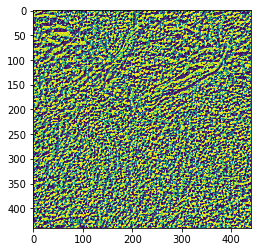

Processing: 15_L3L_2_PTA_48h_Rec_surface_mean.dat


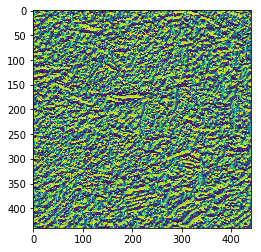

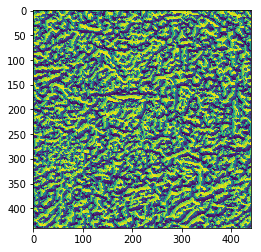

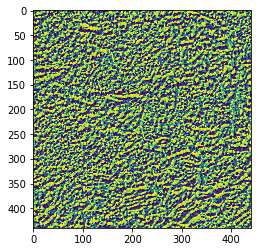

Processing: 15_L6TL_2_PTA_48h_Rec_surface_mean.dat


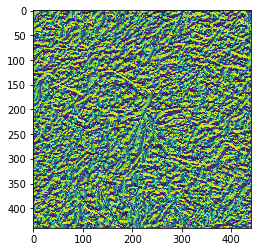

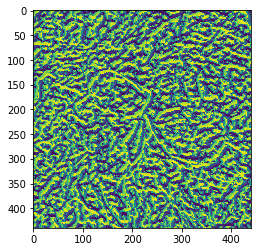

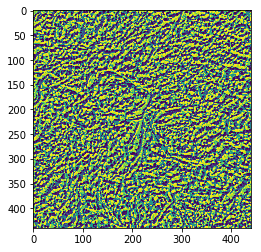

Processing: 15_L6TL_2_surface_mean.dat


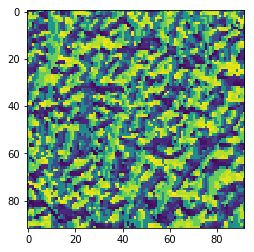

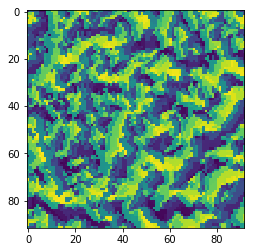

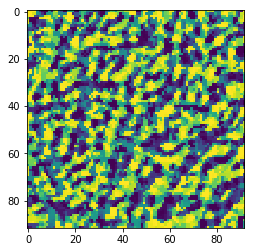

Processing: 20_R2M_2_PTA_48h_Rec_surface_mean.dat


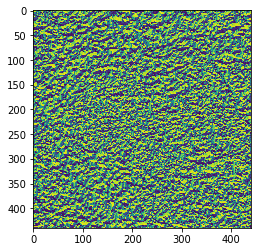

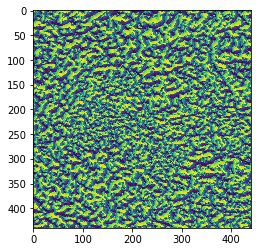

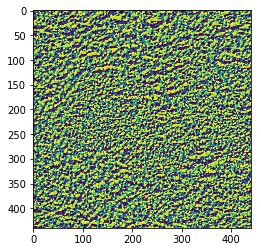

Processing: 20_R6TM_2_PTA_48h_Rec_surface_mean.dat


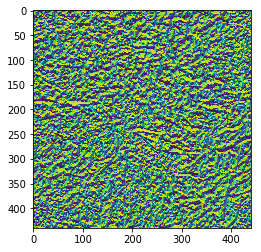

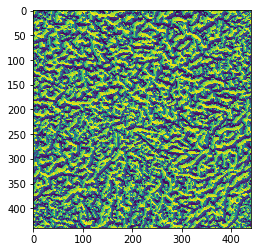

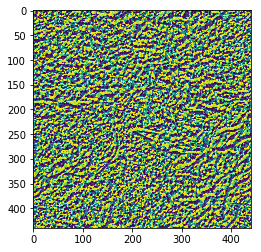

Processing: 21_L3L_2_PTA_48h_Rec_surface_mean.dat


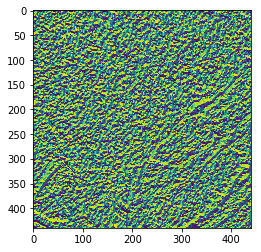

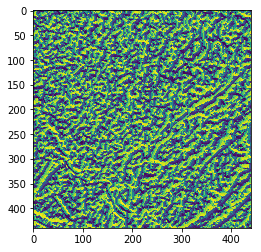

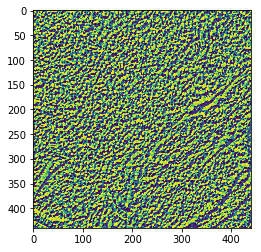

Processing: 21_L6LT_1_PTA_48h_Rec_surface_mean.dat


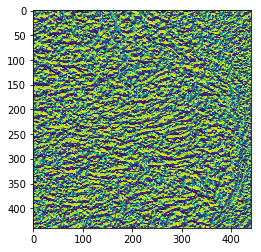

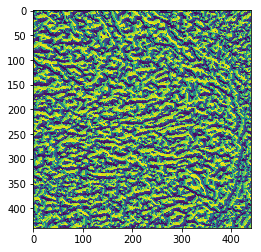

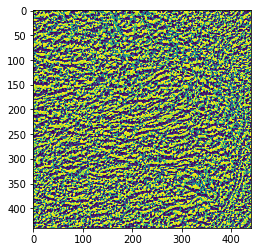

Processing: 22_L3L_2_PTA_48h_Rec_surface_mean.dat


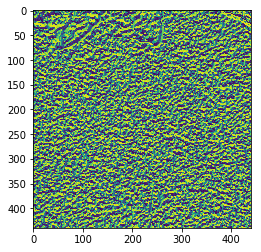

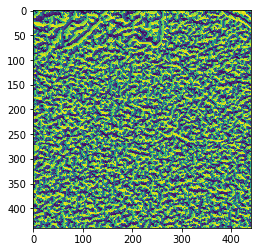

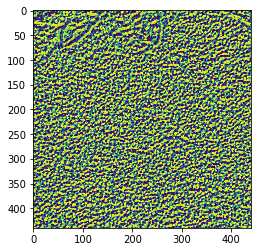

Processing: 22_L6TL_2_PTA_48h_Rec_surface_mean.dat


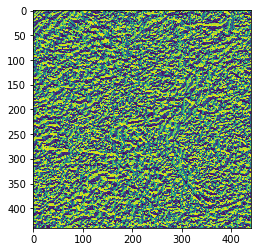

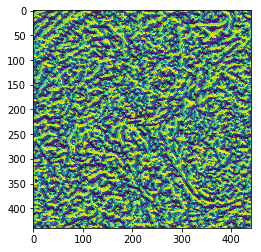

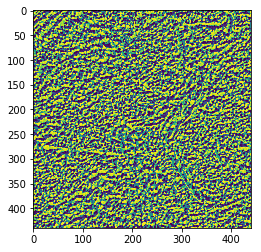

Processing: 23_R3L_2_PTA_48h_Rec_surface_mean.dat


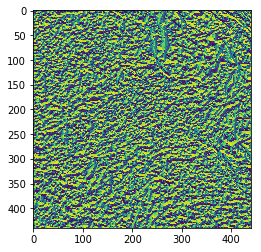

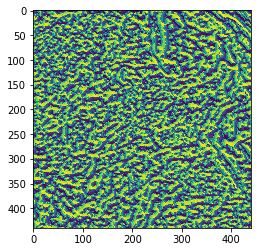

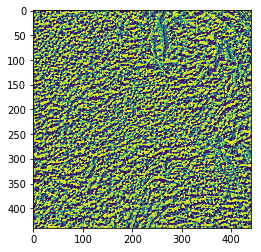

Processing: 23_R6LT_2_PTA_48h_Rec_surface_mean.dat


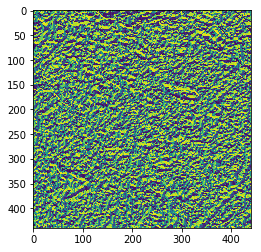

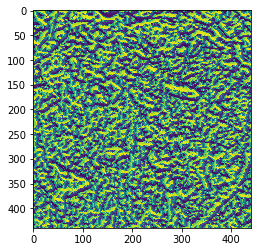

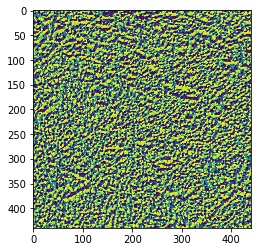

Processing: 24_R3L_2_PTA_48h_Rec_surface_mean.dat


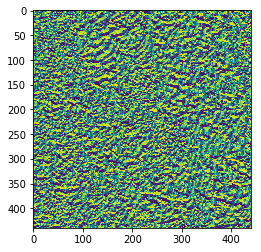

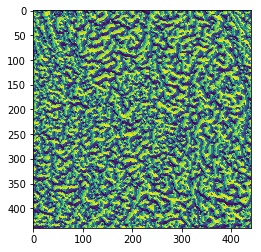

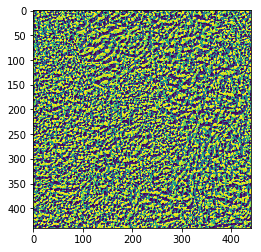

Processing: 25_L3L_1_PTA_48h_Rec_surface_mean.dat


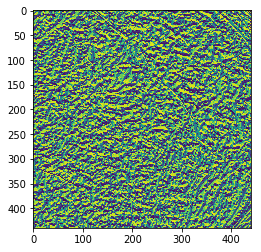

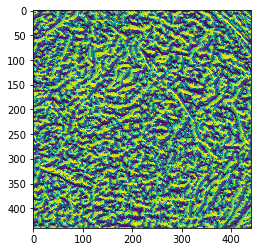

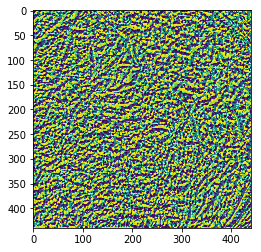

Processing: 26_L3L_2_PTA_48h_Rec_surface_mean.dat


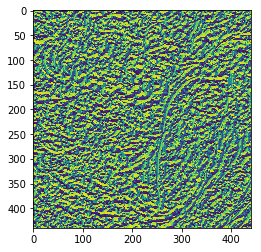

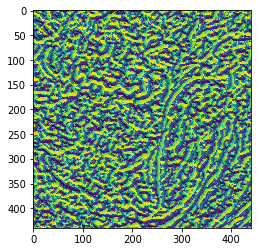

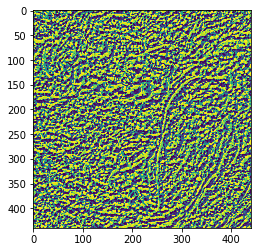

[-9584.54799018 -4938.98242992 -5053.65289686  1464.24444831  1725.13324426
   126.75920641  -135.93020883  -316.58974636    14.18614322   360.31391653]


C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:94: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 18 but corresponding boolean dimension is 36


IndexError: index 19 is out of bounds for axis 0 with size 18

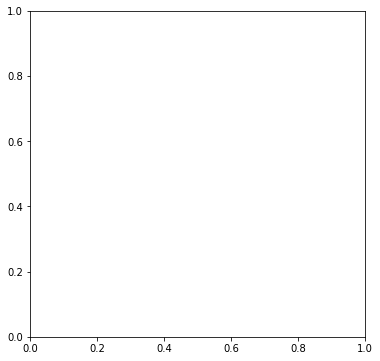

In [5]:
#Start time
start_time = time.time()
impath = r'Z:\3DHistoData\SurfaceImages\Surface'
savepath = r'Z:\3DHistoData\Grading'

# Load grades to array
grades = pd.read_excel(r'Z:\3DHistoData\SurfaceImages' + r'\PTAgreiditjanaytteet.xls', 'Sheet1')
grades = pd.DataFrame(grades).values
g = grades[:,2].astype('int')
grades = grades[:,1:2]

#Calculate MRELBP from dataset

# Parameters
dict = {'N':8, 'R':3,'r':1,'wc':3,'wr':(3,3)}
mapping = getmapping(dict['N']) # mapping

files = os.listdir(impath)
files.sort()

print(files)
features = None # Reset feature array

for k in range(0, len(files), 2):
    #Load file
    print('Processing: ' + files[k])
    
    file = os.path.join(impath,files[k])
    try:
        Mz = loadbinary(file, np.float64)
    except:
        continue
    file = os.path.join(impath,files[k + 1])
    try:
        sz = loadbinary(file, np.float64)
    except:
        continue
    
    #Combine mean and sd images
    image = Mz+sz
    #Grayscale normalization
    image = localstandard(image,23,5,5,1)
    #print(image[0,:]) # Normalized image
    # LBP
    Chist,Lhist,Shist,Rhist, lbpIL, lbpIS, lbpIR = MRELBP(image,dict['N'],dict['R'],dict['r'],dict['wc'],dict['wr'])
    f1 = Chist
    f2 = maplbp(Lhist,mapping)
    f3 = maplbp(Shist,mapping)
    f4 = maplbp(Rhist,mapping)
    #Concatenate features
    f = np.concatenate((f1.T,f2.T,f3.T,f4.T),axis=0)
    try:
        features = np.concatenate((features,f),axis=1)
    except ValueError:
        features = f
    # Save images
    cv2.imwrite(savepath + '\\' + files[k][:-9] + '.png', lbpIL)
    plt.imshow(lbpIS)
    plt.show()
    plt.imshow(lbpIL)
    plt.show()
    plt.imshow(lbpIR)
    plt.show()

# Save features
writer = pd.ExcelWriter(savepath + r'\LBP_features_python.xlsx')
df1 = pd.DataFrame(features)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()

#PCA
pca, score = ScikitPCA(features.T,10)
#pca, score = PCA(features,10)
print(score[0,:])

pred1 = regress(score,g)
pred2 = logreg(score,g>0)
for p in range(len(pred1)):
    if pred1[p]<0:
        pred1[p] = 0
    if pred1[p] > 3:
        pred1[p]=3

#Plotting the prediction
a = g
b = np.round(pred1).astype('int')	

#Plotting
x = score[:,0]
y = score[:,1]
fig = plt.figure(figsize=(6,6))
#plt.grid(True)
ax1 = fig.add_subplot(111)
ax1.scatter(score[g<2,0],score[g<2,1],marker='o',color='b',label='Normal')	
ax1.scatter(score[g>1,0],score[g>1,1],marker='s',color='r',label='OA')

for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])		
    if grades[k,0] >= 2:
        ax1.scatter(x[k],y[k],marker='s',color='r')
        #ax1.annotate(txt,xy=(x[k],y[k]),color='r')
    else:
        ax1.scatter(x[k],y[k],marker='o',color='b')
        #ax1.annotate(txt,xy=(x[k],y[k]),color='b')	

C1 = skmet.confusion_matrix(a,b)
MSE1 = skmet.mean_squared_error(a,pred1)
fpr, tpr, thresholds = skmet.roc_curve(a>0, np.round(pred1)>0, pos_label=1)
AUC1 = skmet.auc(fpr,tpr)
AUC1 = skmet.roc_auc_score(a>0,pred2)
t = time.time()-start_time
m, b = np.polyfit(a, pred1.flatten(), 1)
R2 = skmet.r2_score(a,pred1.flatten())
fig0  = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111)
ax0.plot(fpr,tpr)

print('Confusion matrix')
print(C1)
print('Mean squared error, Area under curve')
print(MSE1,AUC1)#,MSE2,MSE3,MSE4)
print("-- %s seconds --" % t)
print('R2 score')
print(R2)
print('Sample, grade, prediction')
for k in range(len(filelist)):
    print(filelist[k],a[k],pred1[k])#,pred3[k])
    
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
ax2.scatter(a,pred1.flatten())
ax2.plot(a,m*a,'-',color='r')
ax2.set_xlabel('Actual grade')
ax2.set_ylabel('Predicted')
for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])
    ax2.annotate(txt,xy=(a[k],pred1[k]),color='r')
plt.show()


In [2]:
# Convert .mat arrays to binary files
path = r'V:\Tuomas\PTASurfaceImages'
savepath = r'V:\Tuomas\PTASurfaceImages_binary'
filelist = os.listdir(path)
for k in range(len(filelist)):
    #Load file
    file = os.path.join(path,filelist[k])
    try:
        file = sio.loadmat(file)
        Mz = file['Mz']
        sz = file['sz']
    except NotImplementedError:
        file = h5py.File(file)
        Mz = file['Mz'][()]
        sz = file['sz'][()]
        
    # Save file
    dtype = 'double'
    Mz = np.float64(Mz)
    sz = np.float64(sz)
    name = filelist[k]
    print(filelist[k])
    writebinaryimage(savepath + '\\' + name[:-4] + '_mean.dat', Mz, dtype)
    writebinaryimage(savepath + '\\' + name[:-4] + '_std.dat', sz, dtype)

22_L6TL_topo.mat


NameError: name 'writebinaryimage' is not defined

In [9]:
# Convert .mat arrays to .png files
path = r'V:\Tuomas\PTASurfaceImages'
savepath = r'V:\Tuomas\PTASurfaceImages_png'
filelist = os.listdir(path)
for k in range(len(filelist)):
    #Load file
    file = os.path.join(path,filelist[k])
    try:
        file = sio.loadmat(file)
        Mz = file['Mz']
        sz = file['sz']
    except NotImplementedError:
        file = h5py.File(file)
        Mz = file['Mz'][()]
        sz = file['sz'][()]
        
    # Save file
    dtype = 'double'
    mx = np.amax(np.float64(Mz))
    mn = np.amin(np.float64(Mz))
    Mbmp = (np.float64(Mz) - mn) * (255 / (mx - mn))
    sx = np.amax(np.float64(sz))
    sn = np.amin(np.float64(sz))
    sbmp = (np.float64(sz) - sn) * (255 / (sx - sn))
    name = filelist[k]
    print(filelist[k])
    #print(savepath + '\\' + name[:-4] +'_mean.png')
    cv2.imwrite(savepath + '\\' + name[:-4] +'_mean.png', Mbmp)
    cv2.imwrite(savepath + '\\' + name[:-4] +'_std.png', sbmp)

22_L6TL_topo.mat
O19_L6L_topo.mat
O18_R2M_topo.mat
13_R3L_topo.mat
23_R6LT_topo.mat
26_L3L_topo.mat
O17_R6L_topo.mat
14_R3L_topo.mat
26_L6LT_topo.mat
O19_L3L_topo.mat
25_L6TL_topo.mat
29_R6TM_topo.mat
20_R6TM_topo.mat
28_L3L_topo.mat
31_R6LT_topo.mat
15_L3L_topo.mat
13_R6TL_topo.mat
27R6T_topo.mat
14_R6LT_topo.mat
O17_R3L_topo.mat
24_R6LT_topo.mat
29_R2M_topo.mat
32_L6MT_topo.mat
30_R6TL_topo.mat
22_L3L_topo.mat
21_L3L_topo.mat
27R3M_topo.mat
32_L3L_topo.mat
25_L3L_topo.mat
28_L6MT_topo.mat
21_L6LT_topo.mat
24_R3L_topo.mat
20_R2M_topo.mat
23_R3L_topo.mat
30_R3L_topo.mat
15_L6TL_topo.mat
